# 0. Import packages

In [1]:
import os

import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# 1. Load Base Dataset

In [2]:
INPUT_DIR='./input/'

In [3]:
## Do not change this cell. 
## The reason for this is to prevent cheating using the original data from DACON. 
## If an assertion error occurs in that cell when TAs evaluate the submitted code of each student, it is considered cheating.

train = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
park = pd.read_csv(os.path.join(INPUT_DIR, 'park.csv'))
dcc = pd.read_csv(os.path.join(INPUT_DIR, 'day_care_center.csv'))

assert train.shape[0] == 329690 and train.shape[1] == 13, 'Do not change the format of the input data.'
assert test.shape[0] == 85097 and test.shape[1] == 12, 'Do not change the format of the input data.'
assert park.shape[0] == 1359 and park.shape[1] == 7, 'Do not change the format of the input data.'
assert dcc.shape[0] == 7373 and dcc.shape[1] == 10, 'Do not change the format of the input data.'

# 2. Load additional dataset
- Explain here the additional dataset that you used.
- If you do not use any additional dataset, it's ok and keep empty the below cell.

아파트 실거래가에는 교통이 큰 영향을 줄 것 같다는 생각을 했다. Train.csv와 test.csv에서 제공하는 위도(lat)와 경도(long) 변수를 이용하기 위해서, 지하철 노선의 위도와 경도 데이터를 구하면 도움이 될 것이라고 생각했다. 공공 데이터 포털 data.go.kr 에서 제공하는 ‘전국 도시 철도역사 정보 표준데이터’ 에서 대한민국의 모든 지하철 노선의 위치에 대한 정보를 가져올 수 있었다. subway_seoul_busan.csv 파일은 필요한 정보 위도와 경도를 정리한 csv파일이다.

In [4]:
subway = pd.read_csv(os.path.join(INPUT_DIR, 'subway_seoul_busan.csv'))

# 3. EDA and Preprocessing
- Conduct exploratory data analysis and explain the insights from your analyses.
- Conduct data preprocessing, including feature engineering, and explain your insights that derive such techniques.

In [5]:
train.head()

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day,PRICE
0,0,0,busan,197,125.865988,1993,5,35.149929,129.006071,2021,7,11~20,229250.8
1,1,0,busan,197,101.647190,1993,12,35.149929,129.006071,2021,10,1~10,215320.0
2,2,0,busan,197,91.511175,1993,6,35.149929,129.006071,2020,3,21~31,161740.0
3,3,0,busan,197,101.647190,1993,13,35.149929,129.006071,2020,5,11~20,199781.8
4,4,0,busan,197,101.647190,1993,4,35.149929,129.006071,2022,6,21~30,219606.4


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329690 entries, 0 to 329689
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              329690 non-null  int64  
 1   apartment_id       329690 non-null  int64  
 2   city               329690 non-null  object 
 3   dong               329690 non-null  int64  
 4   house_area         329690 non-null  float64
 5   built_year         329690 non-null  int64  
 6   floor              329690 non-null  int64  
 7   lat                329601 non-null  float64
 8   long               329601 non-null  float64
 9   transaction_year   329690 non-null  int64  
 10  transaction_month  329690 non-null  int64  
 11  transaction_day    329690 non-null  object 
 12  PRICE              329690 non-null  float64
dtypes: float64(4), int64(7), object(2)
memory usage: 32.7+ MB


In [7]:
train = train.rename({'transaction_year':'tr_year'}, axis=1)
test = test.rename({'transaction_year':'tr_year'}, axis=1)

In [8]:
all = pd.concat([train, test], ignore_index=True)

In [9]:
all.isna().sum()

index                    0
apartment_id             0
city                     0
dong                     0
house_area               0
built_year               0
floor                    0
lat                    102
long                   102
tr_year                  0
transaction_month        0
transaction_day          0
PRICE                85097
dtype: int64

In [10]:
"""import pandas_profiling
all.profile_report()"""

'import pandas_profiling\nall.profile_report()'

<AxesSubplot:>

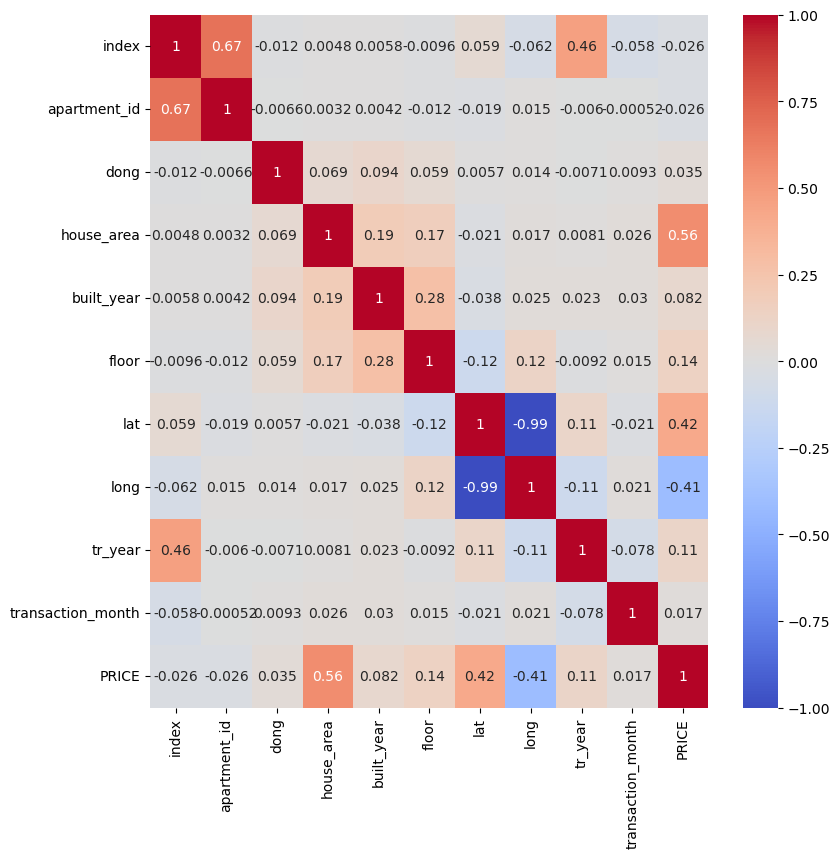

In [11]:
plt.figure(figsize=(9,9))
corr = all.corr()
sns.heatmap(corr, vmax=1, vmin=-1, center=0, annot=True, cmap='coolwarm')

'PRICE'와의 상관계수를 살펴보면, 'house_area'가 0.56으로 큰 관련이 있음을 알 수 있다.

## Feature Engineering

### city

In [12]:
all['city'].unique()

array(['busan', 'seoul'], dtype=object)

In [13]:
all['city'] = all['city'].map({'seoul':1, 'busan':0})

all['city'].value_counts()

1    244654
0    170133
Name: city, dtype: int64

이 변수의 타입은 ‘object’이므로 모델 학습의 편의를 위해 임의로 ‘seoul’에 1을, ‘busan’에 0을 배정하였다.

### transaction_year_month

In [14]:
all['tr_ym'] = (all['tr_year'] - 2018) * 12 + all['transaction_month']
all

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,tr_year,transaction_month,transaction_day,PRICE,tr_ym
0,0,0,0,197,125.865988,1993,5,35.149929,129.006071,2021,7,11~20,229250.8,43
1,1,0,0,197,101.647190,1993,12,35.149929,129.006071,2021,10,1~10,215320.0,46
2,2,0,0,197,91.511175,1993,6,35.149929,129.006071,2020,3,21~31,161740.0,27
3,3,0,0,197,101.647190,1993,13,35.149929,129.006071,2020,5,11~20,199781.8,29
4,4,0,0,197,101.647190,1993,4,35.149929,129.006071,2022,6,21~30,219606.4,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414782,414782,4419,1,37,100.821957,2014,8,37.452039,127.070842,2023,10,21~31,NaN,70
414783,414783,4419,1,37,101.431912,2014,11,37.452039,127.070842,2023,10,21~31,NaN,70
414784,414784,4419,1,37,121.201627,2014,12,37.452039,127.070842,2023,11,1~10,NaN,71
414785,414785,4419,1,37,137.192013,2014,3,37.452039,127.070842,2023,11,21~30,NaN,71


In [15]:
all = all.drop(['transaction_month', 'transaction_day'], axis=1)

### house_area

In [16]:
all['pyung'] = all['house_area'] // 10 * 10           # 10제곱미터 단위
#all['pyung'] = all['house_area'] * 0.3025 // 5 * 5   # 5평 단위

all.sort_values('house_area')

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,tr_year,PRICE,tr_ym,pyung
37208,37208,426,1,1,14.399720,2013,9,37.475163,126.886296,2022,134950.000,58,10.0
37222,37222,426,1,1,14.399720,2013,13,37.475163,126.886296,2019,110303.200,24,10.0
37197,37197,426,1,1,14.399720,2013,10,37.475163,126.886296,2021,134950.000,46,10.0
37220,37220,426,1,1,14.399720,2013,14,37.475163,126.886296,2019,139236.400,22,10.0
37217,37217,426,1,1,14.399720,2013,14,37.475163,126.886296,2019,111910.600,24,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249823,249823,3375,1,42,315.657641,2012,9,37.513261,127.031560,2018,4855348.000,10,310.0
369066,369066,2057,1,146,316.100157,1978,13,37.532109,127.030016,2023,NaN,62,310.0
78679,78679,1006,0,171,322.514251,2009,44,35.161840,129.142776,2020,2037040.000,28,320.0
112189,112189,1484,1,118,324.651486,2011,44,37.543500,127.037420,2018,5893867.708,4,320.0


면적을 나타내는 ‘house_area’ 변수는 총 9,240개의 서로 다른 값을 가지고 있는 변수이다. 이를 그룹화하면 모델 학습과 EDA에 도움이 될 것 같아, 위의 코드처럼 작성했다.

In [17]:
all.loc[all['pyung']<10, 'pyung'] = 10.0
all.loc[all['pyung']>=300, 'pyung'] = 300.0

#all.loc[all['pyung']>95, 'pyung'] = 95.0

all.sort_values('house_area')

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,tr_year,PRICE,tr_ym,pyung
37208,37208,426,1,1,14.399720,2013,9,37.475163,126.886296,2022,134950.000,58,10.0
37222,37222,426,1,1,14.399720,2013,13,37.475163,126.886296,2019,110303.200,24,10.0
37197,37197,426,1,1,14.399720,2013,10,37.475163,126.886296,2021,134950.000,46,10.0
37220,37220,426,1,1,14.399720,2013,14,37.475163,126.886296,2019,139236.400,22,10.0
37217,37217,426,1,1,14.399720,2013,14,37.475163,126.886296,2019,111910.600,24,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249823,249823,3375,1,42,315.657641,2012,9,37.513261,127.031560,2018,4855348.000,10,300.0
369066,369066,2057,1,146,316.100157,1978,13,37.532109,127.030016,2023,NaN,62,300.0
78679,78679,1006,0,171,322.514251,2009,44,35.161840,129.142776,2020,2037040.000,28,300.0
112189,112189,1484,1,118,324.651486,2011,44,37.543500,127.037420,2018,5893867.708,4,300.0


### dong

train, test data의 동 개수

In [18]:
train_dong = set(train['dong'])
test_dong = set(test['dong'])

print('*** 동 개수 ***')
print(f'train data: {len(train_dong)}')
print(f'test data : {len(test_dong)}')
print(f'test data only: {len(test_dong - train_dong)}')

*** 동 개수 ***
train data: 203
test data : 202
test data only: 0


서울과 부산의 같은 동 이름 구분

In [19]:
cnt = len(all['dong'].unique())
print(f'Before: {cnt}')

seoul_dong = set(all.loc[all['city']==1, 'dong'])
busan_dong = set(all.loc[all['city']==0, 'dong'])
same_dong = seoul_dong & busan_dong
print(f'Same dong: {same_dong}')

for d in same_dong:
    all.loc[(all['city']==1) & (all['dong']==d), 'dong'] = 1000 + d
    all.loc[(all['city']==0) & (all['dong']==d), 'dong'] = 2000 + d

cnt = len(all['dong'].unique())
print(f'After: {cnt}')

Before: 203
Same dong: {120}
After: 204


dong 별로 가격을 조사해 dprice에 저장

In [20]:
trn_sz = len(train)
trn = all[:trn_sz]

# dprice11
dong_df = trn.groupby('dong')['PRICE'].agg('mean').reset_index()
dong_df = dong_df.rename({'PRICE':'dprice11'}, axis=1)
all = pd.merge(all, dong_df, on='dong', how='left')

# dprice21
dong_df = trn.groupby(['dong', 'pyung'])['PRICE'].agg('mean').reset_index()
dong_df = dong_df.rename({'PRICE':'dprice21'}, axis=1)
all = pd.merge(all, dong_df, on=['dong', 'pyung'], how='left')

# dprice22 (K)
dong_df = trn.groupby(['dong', 'tr_year'])['PRICE'].agg('mean').reset_index()
dong_df = dong_df.rename({'PRICE':'dprice22'}, axis=1)

dong_values = dong_df['dong'].unique()
new_rows = []
for d in dong_values:
    new_row = {'dong': d, 'tr_year': 2023}
    new_rows.append(new_row)

dong_df = dong_df.append(new_rows, ignore_index=True)
dong_df = dong_df.sort_values(['dong', 'tr_year'])
dong_df['dprice22'] = dong_df['dprice22'].fillna(method='ffill')
all = pd.merge(all, dong_df, on=['dong', 'tr_year'], how='left')

# dprice31
#year_df = trn.groupby(['dong', 'pyung', 'tr_year'])['PRICE'].agg('mean').reset_index()
#last_rows = trn.groupby(['dong', 'pyung']).apply(lambda x: x.sort_values('tr_year').tail(1))
#ong_df = last_rows[['dong', 'pyung', 'tr_year']].reset_index(drop=True)
#ong_df = pd.merge(dong_df, year_df, on=['dong', 'pyung', 'tr_year'], how='left')
#ong_df = dong_df.rename({'PRICE':'dprice31', 'tr_year':'d31_yr'}, axis=1)
#ll = pd.merge(all, dong_df, on=['dong', 'pyung'], how='left')

# dprice32
ym_df = trn.groupby(['dong', 'pyung', 'tr_ym'])['PRICE'].agg('mean').reset_index()
last_rows = trn.groupby(['dong', 'pyung']).apply(lambda x: x.sort_values('tr_ym').tail(1))
dong_df = last_rows[['dong', 'pyung', 'tr_ym']].reset_index(drop=True)
dong_df = pd.merge(dong_df, ym_df, on=['dong', 'pyung', 'tr_ym'], how='left')
dong_df = dong_df.rename({'PRICE':'dprice32', 'tr_ym':'d32_ym'}, axis=1)
all = pd.merge(all, dong_df, on=['dong', 'pyung'], how='left')

all

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,tr_year,PRICE,tr_ym,pyung,dprice11,dprice21,dprice22,d32_ym,dprice32
0,0,0,0,197,125.865988,1993,5,35.149929,129.006071,2021,229250.8,43,120.0,198805.335373,224891.336364,202011.336479,58.0,2.571124e+05
1,1,0,0,197,101.647190,1993,12,35.149929,129.006071,2021,215320.0,46,100.0,198805.335373,230058.104584,202011.336479,60.0,2.523667e+05
2,2,0,0,197,91.511175,1993,6,35.149929,129.006071,2020,161740.0,27,90.0,198805.335373,210738.910000,196299.661467,59.0,2.013892e+05
3,3,0,0,197,101.647190,1993,13,35.149929,129.006071,2020,199781.8,29,100.0,198805.335373,230058.104584,196299.661467,60.0,2.523667e+05
4,4,0,0,197,101.647190,1993,4,35.149929,129.006071,2022,219606.4,54,100.0,198805.335373,230058.104584,214720.853746,60.0,2.523667e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414782,414782,4419,1,37,100.821957,2014,8,37.452039,127.070842,2023,NaN,70,100.0,800066.806614,769612.754286,917782.000000,60.0,9.332920e+05
414783,414783,4419,1,37,101.431912,2014,11,37.452039,127.070842,2023,NaN,70,100.0,800066.806614,769612.754286,917782.000000,60.0,9.332920e+05
414784,414784,4419,1,37,121.201627,2014,12,37.452039,127.070842,2023,NaN,71,120.0,800066.806614,837152.413778,917782.000000,58.0,1.013662e+06
414785,414785,4419,1,37,137.192013,2014,3,37.452039,127.070842,2023,NaN,71,130.0,800066.806614,904853.343400,917782.000000,60.0,1.126180e+06


변수 ‘dong’(동)‘을 같은 것끼리 묶어서, ‘같은 동에 속하는 아파트들의 실거래가의 평균’을 구한다면, ‘PRICE’ 변수와 밀접한 관련이 있을 것이라는 추론을 하게 되었다. 
그래서 위의 코드처럼 dprice11, dprice21, dprice22, dprice32 변수를 새롭게 추가했다.
dprice21: 같은 동, 같은 ‘pyung’을 가진 ‘PRICE’의 평균
dprice22: 같은 동, 같은 ‘tr_year’을 가진 ‘PRICE’의 평균
dprice32: 같은 동, 같은 ‘pyung’, 가장 큰(나중) ‘tr_ym’을 가진 ‘PRICE’의 평균


In [21]:
all.isna().sum()

index               0
apartment_id        0
city                0
dong                0
house_area          0
built_year          0
floor               0
lat               102
long              102
tr_year             0
PRICE           85097
tr_ym               0
pyung               0
dprice11            0
dprice21           57
dprice22            0
d32_ym             57
dprice32           57
dtype: int64

In [22]:
all['dprice21'] = all['dprice21'].fillna(all['dprice11'])
all['dprice22'] = all['dprice22'].fillna(all['dprice11'])
#all['dprice31'] = all['dprice31'].fillna(all['dprice11'])
all['dprice32'] = all['dprice32'].fillna(all['dprice11'])

all.isna().sum()

index               0
apartment_id        0
city                0
dong                0
house_area          0
built_year          0
floor               0
lat               102
long              102
tr_year             0
PRICE           85097
tr_ym               0
pyung               0
dprice11            0
dprice21            0
dprice22            0
d32_ym             57
dprice32            0
dtype: int64

### apartment_id

train, test data의 apt 개수

In [23]:
train_apt = set(train['apartment_id'])
test_apt = set(test['apartment_id'])

print('*** Apt 개수 ***')
print(f'train data: {len(train_apt)}')
print(f'test data : {len(test_apt)}')
print(f'test data only: {len(test_apt - train_apt)}')

*** Apt 개수 ***
train data: 4419
test data : 3957
test data only: 1


서울과 부산에 같은 아파트 ID가 있는지 확인

In [24]:
seoul_apt = set(all.loc[all['city']==1, 'apartment_id'])
busan_apt = set(all.loc[all['city']==0, 'apartment_id'])

print('*** Apt 개수 ***')
print(f'서울: {len(seoul_apt)}')
print(f'부산: {len(busan_apt)}')
print(f'공통: {len(seoul_apt & busan_apt)}')

*** Apt 개수 ***
서울: 2526
부산: 1894
공통: 0


apartment_id 별로 가격을 조사해 aprice에 저장

In [25]:
trn_sz = len(train)
trn = all[:trn_sz]

# aprice11
apt_df = trn.groupby('apartment_id')['PRICE'].agg('mean').reset_index()
apt_df = apt_df.rename({'PRICE':'aprice11'}, axis=1)
all = pd.merge(all, apt_df, on='apartment_id', how='left')

# aprice21
apt_df = trn.groupby(['apartment_id', 'pyung'])['PRICE'].agg('mean').reset_index()
apt_df = apt_df.rename({'PRICE':'aprice21'}, axis=1)
all = pd.merge(all, apt_df, on=['apartment_id', 'pyung'], how='left')

# aprice22 (K)
apt_df = trn.groupby(['apartment_id', 'tr_year'])['PRICE'].agg('mean').reset_index()
apt_df = apt_df.rename({'PRICE':'aprice22'}, axis=1)

apt_values = apt_df['apartment_id'].unique()
new_rows = []
for a in apt_values:
    new_row = {'apartment_id': a, 'tr_year': 2023}
    new_rows.append(new_row)

apt_df = apt_df.append(new_rows, ignore_index=True)
apt_df = apt_df.sort_values(['apartment_id', 'tr_year'])
apt_df['aprice22'] = apt_df['aprice22'].fillna(method='ffill')
all = pd.merge(all, apt_df, on=['apartment_id', 'tr_year'], how='left')

# aprice31
#year_df = trn.groupby(['apartment_id', 'pyung', 'tr_year'])['PRICE'].agg('mean').reset_index()
#last_rows = trn.groupby(['apartment_id', 'pyung']).apply(lambda x: x.sort_values('tr_year').tail(1))
#apt_df = last_rows[['apartment_id', 'pyung', 'tr_year']].reset_index(drop=True)
#apt_df = pd.merge(apt_df, year_df, on=['apartment_id', 'pyung', 'tr_year'], how='left')
#apt_df = apt_df.rename({'PRICE':'aprice31', 'tr_year':'a31_yr'}, axis=1)
#all = pd.merge(all, apt_df, on=['apartment_id', 'pyung'], how='left')

# aprice32
ym_df = trn.groupby(['apartment_id', 'pyung', 'tr_ym'])['PRICE'].agg('mean').reset_index()
last_rows = trn.groupby(['apartment_id', 'pyung']).apply(lambda x: x.sort_values('tr_ym').tail(1))
apt_df = last_rows[['apartment_id', 'pyung', 'tr_ym']].reset_index(drop=True)
apt_df = pd.merge(apt_df, ym_df, on=['apartment_id', 'pyung', 'tr_ym'], how='left')
apt_df = apt_df.rename({'PRICE':'aprice32', 'tr_ym':'a32_ym'}, axis=1)
all = pd.merge(all, apt_df, on=['apartment_id', 'pyung'], how='left')

all

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,tr_year,...,dprice11,dprice21,dprice22,d32_ym,dprice32,aprice11,aprice21,aprice22,a32_ym,aprice32
0,0,0,0,197,125.865988,1993,5,35.149929,129.006071,2021,...,198805.335373,224891.336364,202011.336479,58.0,2.571124e+05,207841.001657,224891.336364,222305.244444,58.0,257112.4
1,1,0,0,197,101.647190,1993,12,35.149929,129.006071,2021,...,198805.335373,230058.104584,202011.336479,60.0,2.523667e+05,207841.001657,195893.107216,222305.244444,60.0,224964.4
2,2,0,0,197,91.511175,1993,6,35.149929,129.006071,2020,...,198805.335373,210738.910000,196299.661467,59.0,2.013892e+05,207841.001657,166893.135294,202643.200000,59.0,192816.4
3,3,0,0,197,101.647190,1993,13,35.149929,129.006071,2020,...,198805.335373,230058.104584,196299.661467,60.0,2.523667e+05,207841.001657,195893.107216,202643.200000,60.0,224964.4
4,4,0,0,197,101.647190,1993,4,35.149929,129.006071,2022,...,198805.335373,230058.104584,214720.853746,60.0,2.523667e+05,207841.001657,195893.107216,222099.034783,60.0,224964.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414782,414782,4419,1,37,100.821957,2014,8,37.452039,127.070842,2023,...,800066.806614,769612.754286,917782.000000,60.0,9.332920e+05,798449.571520,765744.188235,918706.333333,60.0,933292.0
414783,414783,4419,1,37,101.431912,2014,11,37.452039,127.070842,2023,...,800066.806614,769612.754286,917782.000000,60.0,9.332920e+05,798449.571520,765744.188235,918706.333333,60.0,933292.0
414784,414784,4419,1,37,121.201627,2014,12,37.452039,127.070842,2023,...,800066.806614,837152.413778,917782.000000,58.0,1.013662e+06,798449.571520,837152.413778,918706.333333,58.0,1013662.0
414785,414785,4419,1,37,137.192013,2014,3,37.452039,127.070842,2023,...,800066.806614,904853.343400,917782.000000,60.0,1.126180e+06,798449.571520,904853.343400,918706.333333,60.0,1126180.0


‘dong’에서 변수를 추가한 것과 비슷한 아이디어를 적용하여, 'apartment_id' 또한 같은 아파트 단지의 평균을 이용해서 ‘aprice11’, ‘aprice21’, ‘aprice22’, ‘aprice32’ 변수를 추가하였다. 

In [26]:
all.isna().sum()

index               0
apartment_id        0
city                0
dong                0
house_area          0
built_year          0
floor               0
lat               102
long              102
tr_year             0
PRICE           85097
tr_ym               0
pyung               0
dprice11            0
dprice21            0
dprice22            0
d32_ym             57
dprice32            0
aprice11           36
aprice21          660
aprice22           36
a32_ym            660
aprice32          660
dtype: int64

In [27]:
all['aprice11'] = all['aprice11'].fillna(all['dprice11'])
all['aprice21'] = all['aprice21'].fillna(all['aprice11'])
all['aprice22'] = all['aprice22'].fillna(all['aprice11'])
#all['aprice31'] = all['aprice31'].fillna(all['aprice11'])
all['aprice32'] = all['aprice32'].fillna(all['aprice11'])

all.isna().sum()

index               0
apartment_id        0
city                0
dong                0
house_area          0
built_year          0
floor               0
lat               102
long              102
tr_year             0
PRICE           85097
tr_ym               0
pyung               0
dprice11            0
dprice21            0
dprice22            0
d32_ym             57
dprice32            0
aprice11            0
aprice21            0
aprice22            0
a32_ym            660
aprice32            0
dtype: int64

### floor

* 음수 층은 3개 아파트에 24건의 거래가 있음
* 테스트 데이터의 음수 층은 2개 아파트의 3건이며, -1층과 -3층임
* 양수, 음수에 상관없이 넓이에 비례해 PRICE가 증가하므로, 음수 층은 절대값을 씌워 양수 층으로 변환

In [28]:
all[all['floor']<0]['index'].count()

24

In [29]:
all[all['floor']<0].groupby('apartment_id')['index'].count().sort_values(ascending=False)

apartment_id
276     16
1526     5
2123     3
Name: index, dtype: int64

In [30]:
all[(all['PRICE'].isna()) & (all['floor']<0)]

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,tr_year,...,dprice11,dprice21,dprice22,d32_ym,dprice32,aprice11,aprice21,aprice22,a32_ym,aprice32
335106,335106,276,1,202,160.836735,2010,-1,37.642117,126.935430,2023,...,555725.082361,695542.421992,615790.077620,60.0,724685.414,624473.346049,659496.414000,667231.133500,55.0,681824.986
335121,335121,276,1,202,160.872615,2010,-3,37.642117,126.935430,2023,...,555725.082361,695542.421992,615790.077620,60.0,724685.414,624473.346049,659496.414000,667231.133500,55.0,681824.986
359502,359502,1526,1,205,101.324273,2014,-1,37.480951,126.838955,2023,...,426915.355778,436806.361699,481594.539326,60.0,490364.000,465758.791781,449847.314286,497317.082759,60.0,488578.000


In [31]:
all[(all['apartment_id']==276) & (all['floor'].abs()==1)].sort_values('PRICE')

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,tr_year,...,dprice11,dprice21,dprice22,d32_ym,dprice32,aprice11,aprice21,aprice22,a32_ym,aprice32
21180,21180,276,1,202,121.381025,2010,1,37.642117,126.93543,2021,...,555725.082361,609997.499200,542264.115877,60.0,677179.600,624473.346049,623242.400,621300.762857,59.0,641816.800
21162,21162,276,1,202,121.381025,2010,1,37.642117,126.93543,2022,...,555725.082361,609997.499200,615790.077620,60.0,677179.600,624473.346049,623242.400,667231.133500,59.0,641816.800
21147,21147,276,1,202,161.159653,2010,-1,37.642117,126.93543,2018,...,555725.082361,695542.421992,547200.511218,60.0,724685.414,624473.346049,659496.414,609149.967000,55.0,681824.986
21177,21177,276,1,202,121.381025,2010,-1,37.642117,126.93543,2020,...,555725.082361,609997.499200,539748.907554,60.0,677179.600,624473.346049,623242.400,609349.999000,59.0,641816.800
21208,21208,276,1,202,161.159653,2010,-1,37.642117,126.93543,2018,...,555725.082361,695542.421992,547200.511218,60.0,724685.414,624473.346049,659496.414,609149.967000,55.0,681824.986
21175,21175,276,1,202,160.836735,2010,-1,37.642117,126.93543,2019,...,555725.082361,695542.421992,498540.808080,60.0,724685.414,624473.346049,659496.414,565172.396000,55.0,681824.986
21178,21178,276,1,202,200.615363,2010,1,37.642117,126.93543,2022,...,555725.082361,835924.475636,615790.077620,59.0,772552.000,624473.346049,743608.084,667231.133500,59.0,772552.000
21200,21200,276,1,202,200.627322,2010,1,37.642117,126.93543,2021,...,555725.082361,835924.475636,542264.115877,59.0,772552.000,624473.346049,743608.084,621300.762857,59.0,772552.000
21172,21172,276,1,202,200.639282,2010,1,37.642117,126.93543,2022,...,555725.082361,835924.475636,615790.077620,59.0,772552.000,624473.346049,743608.084,667231.133500,59.0,772552.000
335106,335106,276,1,202,160.836735,2010,-1,37.642117,126.93543,2023,...,555725.082361,695542.421992,615790.077620,60.0,724685.414,624473.346049,659496.414,667231.133500,55.0,681824.986


In [32]:
all[(all['apartment_id']==276) & (all['floor'].abs()==3)].sort_values('PRICE')

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,tr_year,...,dprice11,dprice21,dprice22,d32_ym,dprice32,aprice11,aprice21,aprice22,a32_ym,aprice32
21193,21193,276,1,202,101.108995,2010,3,37.642117,126.93543,2019,...,555725.082361,501282.830130,498540.808080,60.0,582781.381818,624473.346049,529298.800,565172.396000,59.0,582610.900
21151,21151,276,1,202,101.073115,2010,3,37.642117,126.93543,2019,...,555725.082361,501282.830130,498540.808080,60.0,582781.381818,624473.346049,529298.800,565172.396000,59.0,582610.900
21187,21187,276,1,202,100.977436,2010,3,37.642117,126.93543,2021,...,555725.082361,501282.830130,542264.115877,60.0,582781.381818,624473.346049,529298.800,621300.762857,59.0,582610.900
21188,21188,276,1,202,121.381025,2010,3,37.642117,126.93543,2022,...,555725.082361,609997.499200,615790.077620,60.0,677179.600000,624473.346049,623242.400,667231.133500,59.0,641816.800
21153,21153,276,1,202,160.872615,2010,-3,37.642117,126.93543,2020,...,555725.082361,695542.421992,539748.907554,60.0,724685.414000,624473.346049,659496.414,609349.999000,55.0,681824.986
21160,21160,276,1,202,161.016134,2010,3,37.642117,126.93543,2021,...,555725.082361,695542.421992,542264.115877,60.0,724685.414000,624473.346049,659496.414,621300.762857,55.0,681824.986
21191,21191,276,1,202,121.381025,2010,3,37.642117,126.93543,2022,...,555725.082361,609997.499200,615790.077620,60.0,677179.600000,624473.346049,623242.400,667231.133500,59.0,641816.800
21137,21137,276,1,202,121.381025,2010,3,37.642117,126.93543,2022,...,555725.082361,609997.499200,615790.077620,60.0,677179.600000,624473.346049,623242.400,667231.133500,59.0,641816.800
21182,21182,276,1,202,121.428865,2010,3,37.642117,126.93543,2022,...,555725.082361,609997.499200,615790.077620,60.0,677179.600000,624473.346049,623242.400,667231.133500,59.0,641816.800
21149,21149,276,1,202,101.073115,2010,3,37.642117,126.93543,2022,...,555725.082361,501282.830130,615790.077620,60.0,582781.381818,624473.346049,529298.800,667231.133500,59.0,582610.900


In [33]:
all[(all['apartment_id']==1526) & (all['floor'].abs()==1)].sort_values('PRICE')

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,tr_year,...,dprice11,dprice21,dprice22,d32_ym,dprice32,aprice11,aprice21,aprice22,a32_ym,aprice32
115713,115713,1526,1,205,101.599350,2014,-1,37.480951,126.838955,2020,...,426915.355778,436806.361699,411660.266560,60.0,490364.0,465758.791781,449847.314286,431389.229412,60.0,488578.0
115707,115707,1526,1,205,101.635230,2014,1,37.480951,126.838955,2020,...,426915.355778,436806.361699,411660.266560,60.0,490364.0,465758.791781,449847.314286,431389.229412,60.0,488578.0
115714,115714,1526,1,205,101.599350,2014,-1,37.480951,126.838955,2020,...,426915.355778,436806.361699,411660.266560,60.0,490364.0,465758.791781,449847.314286,431389.229412,60.0,488578.0
115686,115686,1526,1,205,121.979020,2014,1,37.480951,126.838955,2021,...,426915.355778,495263.852174,448030.218750,58.0,568948.0,465758.791781,495263.852174,491096.260000,58.0,568948.0
359502,359502,1526,1,205,101.324273,2014,-1,37.480951,126.838955,2023,...,426915.355778,436806.361699,481594.539326,60.0,490364.0,465758.791781,449847.314286,497317.082759,60.0,488578.0
359511,359511,1526,1,205,121.979020,2014,1,37.480951,126.838955,2023,...,426915.355778,495263.852174,481594.539326,58.0,568948.0,465758.791781,495263.852174,497317.082759,58.0,568948.0
359514,359514,1526,1,205,101.623270,2014,1,37.480951,126.838955,2023,...,426915.355778,436806.361699,481594.539326,60.0,490364.0,465758.791781,449847.314286,497317.082759,60.0,488578.0


In [34]:
all['floor'] = all['floor'].abs()
all[all['floor']<0]['index'].count()

0

### built_year

In [35]:
all['years'] = all['tr_year'] - all['built_year']

### Heatmap

<AxesSubplot:>

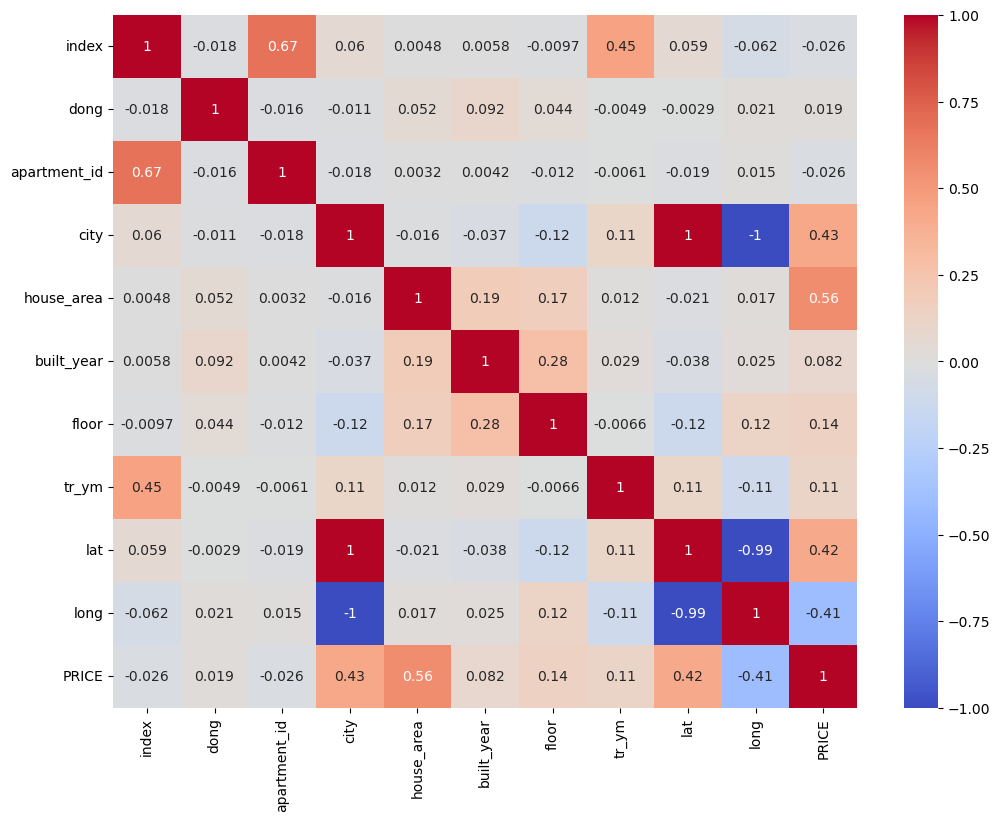

In [36]:
plt.figure(figsize=(12,9))
feature_gr1 = ['index', 'dong', 'apartment_id', 'city', 'house_area', 'built_year', 'floor', 'tr_ym', 'lat', 'long', 'PRICE']
corr1 = all[feature_gr1].corr()
sns.heatmap(corr1, vmax=1, vmin=-1, center=0, annot=True, cmap='coolwarm')

<AxesSubplot:>

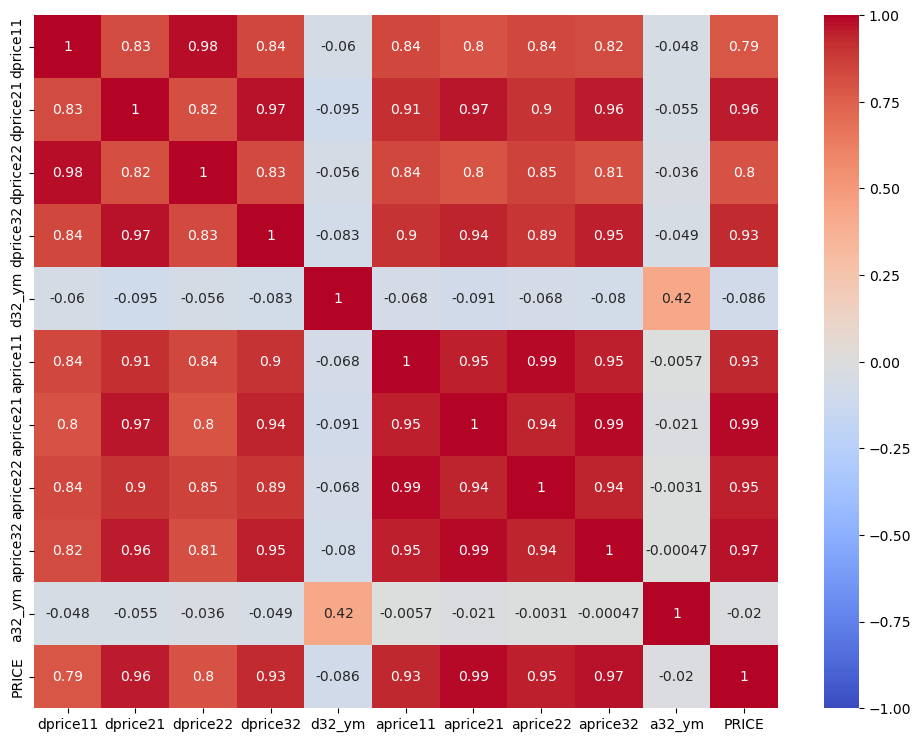

In [37]:
plt.figure(figsize=(12,9))
feature_gr2 = ['dprice11', 'dprice21', 'dprice22', 'dprice32', 'd32_ym', 'aprice11', 'aprice21', 'aprice22', 'aprice32', 'a32_ym', 'PRICE']
corr2 = all[feature_gr2].corr()
sns.heatmap(corr2, vmax=1, vmin=-1, center=0, annot=True, cmap='coolwarm')

aprice 시리즈 변수들이 ‘PRICE’ 변수와 상관계수 0.93~0.97로 매우 높은 관련성을 지닌다는 것을 확인할 수 있었다.
dprice 시리즈 변수들도 높은 관련성을 'PRICE' 변수와 가지고 있다.

## 추가 DB: 지하철역

In [38]:
subway.shape

(842, 2)

In [39]:
subway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     842 non-null    float64
 1   long    842 non-null    float64
dtypes: float64(2)
memory usage: 13.3 KB


In [40]:
subway.head()

,lat,long
0,37.477090,126.963506
1,37.487027,127.059475
2,37.481285,126.952695
3,37.610044,126.930302
4,37.796204,126.792563


In [41]:
apt_df = all.groupby('apartment_id')[['lat', 'long']].first().reset_index()
apt_df['closest_dist'] = np.inf
apt_df['subway_cnt'] = 0

In [42]:
def calc_dist(lat1, long1, lat2, long2):
    return np.sqrt((lat1 - lat2) ** 2 + (long1 - long2) ** 2)

calc_dist()함수는 유클리디안 거리로 두 좌표에 대한 거리를 구하는 함수이다.

In [43]:
for i, row in apt_df.iterrows():
    distances = calc_dist(row['lat'], row['long'], subway['lat'], subway['long'])
    closest_dist = distances.min()
    apt_df.at[i, 'closest_dist'] = closest_dist
    count = (distances <= 0.01).sum()
    apt_df.at[i, 'subway_cnt'] = count

‘subway_cnt’ : 각각의 아파트마다 거리가 0.01 이내인 것의 개수.
'closest_dist': 각각의 아파트에 대해 가장 가까운 지하철 노선과의 거리

In [44]:
sorted = apt_df.sort_values('subway_cnt')
sorted

,apartment_id,lat,long,closest_dist,subway_cnt
4419,4419,37.452039,127.070842,0.016541,0
988,988,37.648020,127.076780,0.013007,0
3468,3468,35.142219,128.984318,0.014937,0
3461,3461,35.172574,129.053953,0.010045,0
1002,1002,35.185855,129.124651,0.018337,0
...,...,...,...,...,...
1235,1235,37.565197,127.013217,0.004253,11
3548,3548,37.565197,127.013217,0.004253,11
3653,3653,37.565197,127.013217,0.004253,11
10,10,37.565197,127.013217,0.004253,11


<AxesSubplot:xlabel='subway_cnt', ylabel='count'>

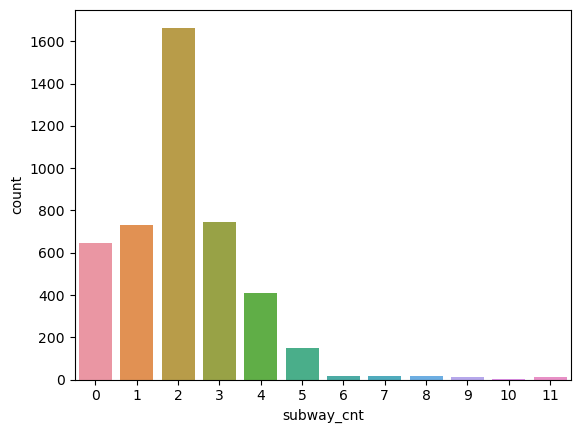

In [45]:
sns.countplot(x='subway_cnt', data=apt_df)

In [46]:
apt_df = apt_df.drop(['lat', 'long'], axis=1)
all = pd.merge(all, apt_df, on='apartment_id', how='left')

all

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,tr_year,...,d32_ym,dprice32,aprice11,aprice21,aprice22,a32_ym,aprice32,years,closest_dist,subway_cnt
0,0,0,0,197,125.865988,1993,5,35.149929,129.006071,2021,...,58.0,2.571124e+05,207841.001657,224891.336364,222305.244444,58.0,257112.4,28,0.003243,2
1,1,0,0,197,101.647190,1993,12,35.149929,129.006071,2021,...,60.0,2.523667e+05,207841.001657,195893.107216,222305.244444,60.0,224964.4,28,0.003243,2
2,2,0,0,197,91.511175,1993,6,35.149929,129.006071,2020,...,59.0,2.013892e+05,207841.001657,166893.135294,202643.200000,59.0,192816.4,27,0.003243,2
3,3,0,0,197,101.647190,1993,13,35.149929,129.006071,2020,...,60.0,2.523667e+05,207841.001657,195893.107216,202643.200000,60.0,224964.4,27,0.003243,2
4,4,0,0,197,101.647190,1993,4,35.149929,129.006071,2022,...,60.0,2.523667e+05,207841.001657,195893.107216,222099.034783,60.0,224964.4,29,0.003243,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414782,414782,4419,1,37,100.821957,2014,8,37.452039,127.070842,2023,...,60.0,9.332920e+05,798449.571520,765744.188235,918706.333333,60.0,933292.0,9,0.016541,0
414783,414783,4419,1,37,101.431912,2014,11,37.452039,127.070842,2023,...,60.0,9.332920e+05,798449.571520,765744.188235,918706.333333,60.0,933292.0,9,0.016541,0
414784,414784,4419,1,37,121.201627,2014,12,37.452039,127.070842,2023,...,58.0,1.013662e+06,798449.571520,837152.413778,918706.333333,58.0,1013662.0,9,0.016541,0
414785,414785,4419,1,37,137.192013,2014,3,37.452039,127.070842,2023,...,60.0,1.126180e+06,798449.571520,904853.343400,918706.333333,60.0,1126180.0,9,0.016541,0


<AxesSubplot:>

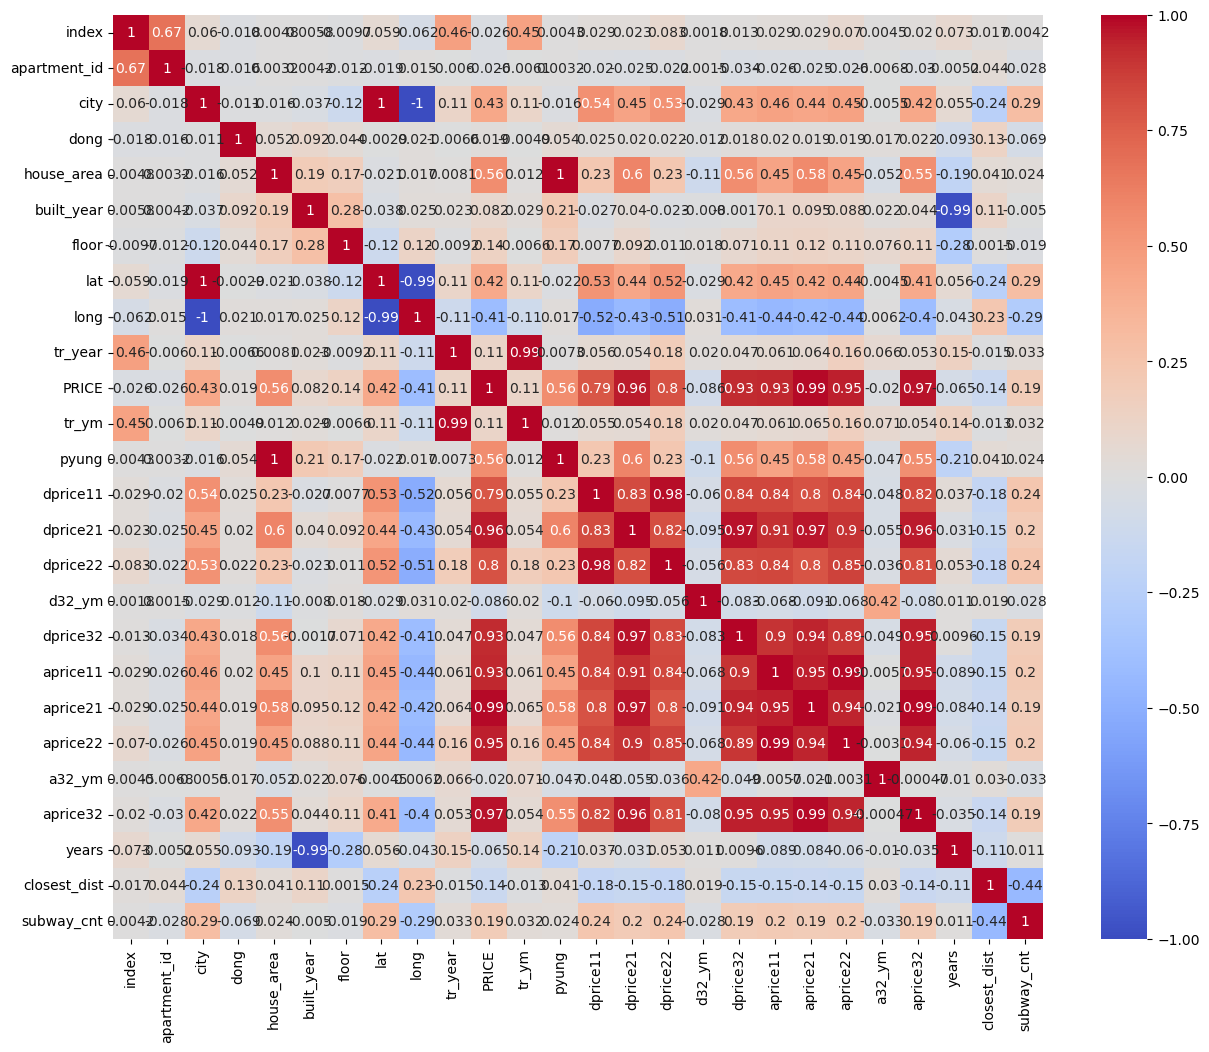

In [47]:
plt.figure(figsize=(15,12))
corr = all.corr()
sns.heatmap(corr, vmax=1, vmin=-1, center=0, annot=True, cmap='coolwarm')

<AxesSubplot:>

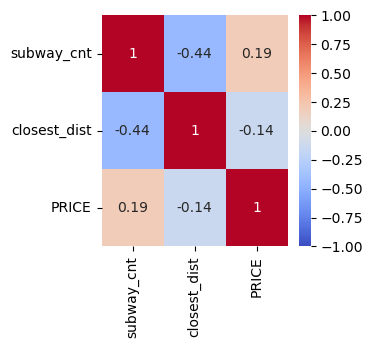

In [48]:
plt.figure(figsize=(3,3))
#corr = all.corr()
corr = all[['subway_cnt', 'closest_dist' , 'PRICE']].corr()
sns.heatmap(corr, vmax=1, vmin=-1, center=0, annot=True, cmap='coolwarm')

### 추가 DB: park

In [49]:
#park = pd.read_csv(data_path + 'park.csv')
park.shape

(1359, 7)

In [50]:
park.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            1359 non-null   object 
 1   gu              1359 non-null   int64  
 2   dong            1359 non-null   int64  
 3   park_name       1359 non-null   object 
 4   park_type       1359 non-null   object 
 5   park_area       1359 non-null   float64
 6   park_open_year  937 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 74.4+ KB


In [51]:
import pandas_profiling
park.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

‘park_open_year’을 제외한 변수는 결측치가 없는 것을 확인할 수 있다.

In [52]:
cnt = len(park['dong'].unique())
print(f'Before: {cnt}')

seoul_dong = set(park.loc[park['city']=='seoul', 'dong'])
busan_dong = set(park.loc[park['city']=='busan', 'dong'])
same_dong = seoul_dong & busan_dong
print(f'Same dong: {same_dong}')

for d in same_dong:
    park.loc[(park['city']=='seoul') & (park['dong']==d), 'dong'] = 1000 + d
    park.loc[(park['city']=='busan') & (park['dong']==d), 'dong'] = 2000 + d

cnt = len(park['dong'].unique())
print(f'After: {cnt}')

Before: 237
Same dong: {120, 208}
After: 239


In [53]:
grouped = park.groupby('dong')

output = []
for _, group in grouped:
    if len(group['gu'].unique()) > 1:
        output.append(group['dong'].iloc[0])

print(output)

[107, 135, 137, 2120]


‘park_cnt’ : ‘dong’에 공원이 몇 개 있는지.
‘park_areas’: ‘dong’에 속해있는 공원의 평균 면적

In [54]:
park_df = park.groupby(['dong'])['park_name'].count().reset_index()
park_df = park_df.rename({'park_name':'park_cnt'}, axis=1)

park2 = park.groupby(['dong'])['park_area'].agg('sum').reset_index()
park2 = park2.rename({'park_area':'park_areas'}, axis=1)

park_df = pd.merge(park_df, park2, on='dong', how='left')
all = pd.merge(all, park_df, on='dong', how='left')

all

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,tr_year,...,aprice11,aprice21,aprice22,a32_ym,aprice32,years,closest_dist,subway_cnt,park_cnt,park_areas
0,0,0,0,197,125.865988,1993,5,35.149929,129.006071,2021,...,207841.001657,224891.336364,222305.244444,58.0,257112.4,28,0.003243,2,7.0,244.075200
1,1,0,0,197,101.647190,1993,12,35.149929,129.006071,2021,...,207841.001657,195893.107216,222305.244444,60.0,224964.4,28,0.003243,2,7.0,244.075200
2,2,0,0,197,91.511175,1993,6,35.149929,129.006071,2020,...,207841.001657,166893.135294,202643.200000,59.0,192816.4,27,0.003243,2,7.0,244.075200
3,3,0,0,197,101.647190,1993,13,35.149929,129.006071,2020,...,207841.001657,195893.107216,202643.200000,60.0,224964.4,27,0.003243,2,7.0,244.075200
4,4,0,0,197,101.647190,1993,4,35.149929,129.006071,2022,...,207841.001657,195893.107216,222099.034783,60.0,224964.4,29,0.003243,2,7.0,244.075200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414782,414782,4419,1,37,100.821957,2014,8,37.452039,127.070842,2023,...,798449.571520,765744.188235,918706.333333,60.0,933292.0,9,0.016541,0,5.0,172.214818
414783,414783,4419,1,37,101.431912,2014,11,37.452039,127.070842,2023,...,798449.571520,765744.188235,918706.333333,60.0,933292.0,9,0.016541,0,5.0,172.214818
414784,414784,4419,1,37,121.201627,2014,12,37.452039,127.070842,2023,...,798449.571520,837152.413778,918706.333333,58.0,1013662.0,9,0.016541,0,5.0,172.214818
414785,414785,4419,1,37,137.192013,2014,3,37.452039,127.070842,2023,...,798449.571520,904853.343400,918706.333333,60.0,1126180.0,9,0.016541,0,5.0,172.214818


In [55]:
#dcc = pd.read_csv(data_path + 'day_care_center.csv')

#dcc_df = dcc.groupby('gu')['day_care_name'].count().reset_index()
#dcc_df = dcc_df.rename({'day_care_name':'dcc_cnt'}, axis=1)
#all = pd.merge(all, dcc_df, on='gu', how='inner')

#all

In [56]:
#all.isna().sum()

<AxesSubplot:>

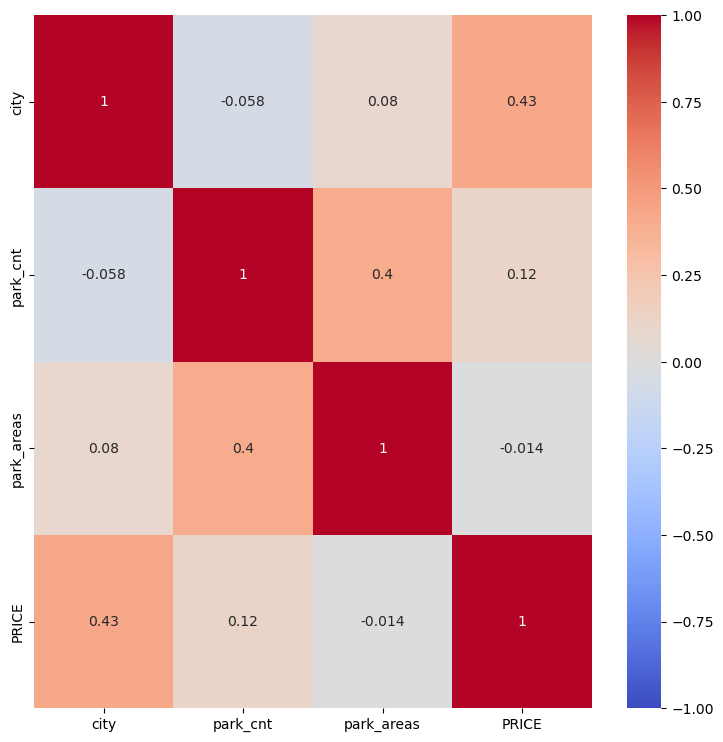

In [57]:
plt.figure(figsize=(9,9))
#corr = all.corr()
corr = all[['city', 'park_cnt', 'park_areas', 'PRICE']].corr()
sns.heatmap(corr, vmax=1, vmin=-1, center=0, annot=True, cmap='coolwarm')

# 4. Modeling

In [58]:
drop_features = ['PRICE', 'index',  'dong', 'apartment_id']
drop_features = drop_features + ['closest_dist', 'subway_cnt', 'park_cnt', 'park_areas']

trn_sz = len(train)
trn = all[:trn_sz]
tst = all[trn_sz:]

y = trn['PRICE']
X = trn.drop(drop_features, axis=1)
X_tst = tst.drop(drop_features, axis=1)

X.shape, y.shape, X_tst.shape

((329690, 20), (329690,), (85097, 20))

In [59]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329690 entries, 0 to 329689
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   city        329690 non-null  int64  
 1   house_area  329690 non-null  float64
 2   built_year  329690 non-null  int64  
 3   floor       329690 non-null  int64  
 4   lat         329601 non-null  float64
 5   long        329601 non-null  float64
 6   tr_year     329690 non-null  int64  
 7   tr_ym       329690 non-null  int64  
 8   pyung       329690 non-null  float64
 9   dprice11    329690 non-null  float64
 10  dprice21    329690 non-null  float64
 11  dprice22    329690 non-null  float64
 12  d32_ym      329690 non-null  float64
 13  dprice32    329690 non-null  float64
 14  aprice11    329690 non-null  float64
 15  aprice21    329690 non-null  float64
 16  aprice22    329690 non-null  float64
 17  a32_ym      329690 non-null  float64
 18  aprice32    329690 non-null  float64
 19  ye

XGBoost과 LightGBM 모델을 교차 검증(Cross Validation)을 이용해 학습하도록 구현했다. 각각의 모델에 대해서 ‘num_leaves’, ‘subsample’등의 매개변수를 제어하기 위해, hyperparameter tuning을 활용했다. LightGBM과 XGBoost 모델의 hyperparameter tuning을 위한 세팅 코드를 각각 작성했다. 대회의 평가함수가 MAE를 사용하므로, ‘metric’은 ‘mae’로 설정했다. Tree_method를 설정할 때는 ‘hist’나 ‘approx’, ‘exact’의 옵션이 있는데, 튜닝 시간이 가장 긴 대신 높은 정확도를 보이는 ‘exact’를 Tree_method로 최종 선택했다. 기본 옵션이 ‘exact’이므로, 따로 명시를 하지 않아도 된다.

### Hyperparameter Tuning

In [60]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [61]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'learning_rate': 0.1,
        "n_estimators": 1000,
        "max_depth": -1,
        "num_leaves": trial.suggest_int("num_leaves", 8, 127),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        'random_state': 42
    }

    model = LGBMRegressor(**params)
    folds = KFold(n_splits=5, shuffle=True, random_state=42)

    score = cross_val_score(model, X, y, cv=folds, scoring="neg_mean_absolute_error")
    return score.mean()

In [62]:
%%time

from optuna.samplers import TPESampler

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler
)

study.optimize(objective, n_trials=10)
#study.optimize(objective, n_trials=10, timeout=6000)

[I 2023-06-05 22:39:28,811] A new study created in memory with name: lgbm_parameter_opt
[I 2023-06-05 22:42:14,971] Trial 0 finished with value: -15564.098766344254 and parameters: {'num_leaves': 52, 'subsample': 0.9802857225639665, 'colsample_bytree': 0.892797576724562}. Best is trial 0 with value: -15564.098766344254.
[I 2023-06-05 22:44:40,123] Trial 1 finished with value: -15338.246392606781 and parameters: {'num_leaves': 79, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481}. Best is trial 1 with value: -15338.246392606781.
[I 2023-06-05 22:45:56,946] Trial 2 finished with value: -16813.170138449965 and parameters: {'num_leaves': 14, 'subsample': 0.9464704583099741, 'colsample_bytree': 0.8404460046972835}. Best is trial 1 with value: -15338.246392606781.
[I 2023-06-05 22:48:32,148] Trial 3 finished with value: -15256.095218087943 and parameters: {'num_leaves': 92, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978}. Best is trial 3 with val

Wall time: 20min 49s


In [63]:
print("Best Score:", study.best_value)
print(study.best_params)

Best Score: -15211.836596829115
{'num_leaves': 107, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402}


학습률, 반복 횟수 값을 직접 지정하고, hyperparameter tuning결과를 통해 얻은 best_parameters 값을 변수에 대입한다. 이후, 전체 데이터를 fold 5개로 분할하여, 각 fold에 대해서 모델을 학습하고 검증하는 교차 검증을 수행하도록 구현했다. 이를 통해 각 fold에서 얻은 validation 점수를 평균하여 모델의 일반화 성능을 추정할 수 있다. 

### Model Training

In [ ]:
%%time

from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

folds = KFold(n_splits=5, shuffle=True, random_state=42)
vld_pred = np.zeros(len(X))
tst_pred = np.zeros(len(X_tst))

params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.01,
    "n_estimators": 10000,
    "max_depth": -1,
    "num_leaves": study.best_params['num_leaves'],
    "subsample": study.best_params['subsample'],
    "colsample_bytree": study.best_params['colsample_bytree'],
    'random_state': 42,
}

for fold_id, (trn_idx, vld_idx) in enumerate(folds.split(X, y)):
    print('\n', '#'*40, f'Fold {fold_id+1} / Fold {folds.n_splits}', '#'*40)    
    X_trn = X.loc[trn_idx]
    y_trn = y.loc[trn_idx]
    X_vld = X.loc[vld_idx]
    y_vld = y.loc[vld_idx]

    model = LGBMRegressor(**params)
    model.fit(X_trn, y_trn, 
              eval_set=[(X_trn, y_trn), (X_vld, y_vld)],
              early_stopping_rounds=50,
              verbose=100
             )

    vld_pred[vld_idx] = model.predict(X_vld)
    tst_pred         += model.predict(X_tst) / folds.n_splits


 ######################################## Fold 1 / Fold 5 ########################################
[100]	training's l1: 83629.8	valid_1's l1: 83496.6
[200]	training's l1: 36577.4	valid_1's l1: 36697.9
[300]	training's l1: 22657.2	valid_1's l1: 22985.2
[400]	training's l1: 19152.9	valid_1's l1: 19603.2
[500]	training's l1: 18033.9	valid_1's l1: 18581.1
[600]	training's l1: 17429	valid_1's l1: 18057.8
[700]	training's l1: 17004.3	valid_1's l1: 17704.7
[800]	training's l1: 16671.4	valid_1's l1: 17431.4
[900]	training's l1: 16411.3	valid_1's l1: 17228.6
[1000]	training's l1: 16212.2	valid_1's l1: 17085.2
[1100]	training's l1: 16029.8	valid_1's l1: 16953.4
[1200]	training's l1: 15873	valid_1's l1: 16849.2
[1300]	training's l1: 15720.7	valid_1's l1: 16747.2
[1400]	training's l1: 15581.7	valid_1's l1: 16651.6
[1500]	training's l1: 15448.9	valid_1's l1: 16561
[1600]	training's l1: 15329.2	valid_1's l1: 16484.3
[1700]	training's l1: 15216.5	valid_1's l1: 16412.7
[1800]	training's l1: 15111.4	v

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y, vld_pred)
print(f'MAE: {mae:.5f}')

# 5. Make submission

In [ ]:
#res_path = '/content/drive/MyDrive/DS/AptPrices_K/output/'

submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))
submission['PRICE'] = tst_pred
#submission.to_csv(res_path+'LGBM_72_0(final).csv', index=False)
submission.to_csv('LGBM_72_0(final).csv', index=False)

submission

## Analysis

### Featue Importance

In [ ]:
import lightgbm as lgb

lgb.plot_importance(model, importance_type='split', title='Feature Importance: split contribution count', xlabel='')
plt.show

lgb.plot_importance(model, importance_type='gain', title='Feature Importance: loss reduction', xlabel='')
plt.show

모델의 특성 중요도를 시각화한 결과이다. 위 그림에서 볼 수 있듯이, 같은 아파트 id와 평을 가진 집 값 평균을 도출한 ‘aprice21’이 가장 큰 영향을 끼치는 변수라는 것을 확인할 수 있었다.

### Hyperparameter 

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

LightGBM 모델에서의 hyperparameter tuning 결과로 도출된, 변수의 중요도 그래프이다. 이 그래프를 통해 LightGBM에서는 num_leaves가 88%의 중요도로 가장 큰 영향을 미친다는 것을 확인할 수 있다.

In [ ]:
# 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# 파라미터들과의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    study,
    params=[
 #       "max_depth",
        "num_leaves",
        "colsample_bytree",
        "subsample",
 #       "subsample_freq",
 #       "min_child_samples",
 #       "max_bin",
    ]
)

### Validation Results

In [ ]:
true_pred_df = pd.DataFrame({
    'true': y,
    'pred': vld_pred
})
true_pred_df.plot(figsize=(12,6), alpha=0.5)

실제값을 의미하는 파란색의 ‘true’가 많이 보이고, 예측값에서 실제값을 뺀 값이 음수가 많다는 것을 확인하게 되었다. 이를 통해, 기존 모델의 예측 값이 실제 ‘PRICE’값보다 전체적으로 낮게 예측하는 경향이 있는 것을 알 수 있다.

In [ ]:
cmp = trn

cmp['PRED'] = vld_pred
cmp['diff'] = cmp['PRED'] - cmp['PRICE']
cmp['diff2'] = cmp['diff'] ** 2
cmp['diff_abs'] = cmp['diff'].abs()

mae2 = (cmp['diff_abs'].sum() / cmp['diff'].count())
print(f'Valid. MAE: {mae2:.5f}')

In [ ]:
cmp_sorted = cmp.sort_values('diff_abs', ascending=False)
features = ['city', 'dong', 'apartment_id', 'floor', 'house_area', 'tr_year', 'built_year', 'dprice21', 'aprice21', 'aprice32', 'PRED', 'PRICE', 'diff', 'diff_abs']
cmp_sorted[features]

In [ ]:
apt_sum = cmp.groupby(['apartment_id'])[['diff2', 'diff_abs']].agg('sum').reset_index()
apt_cnt = cmp.groupby(['apartment_id'])['diff2'].count().reset_index()
apt_cnt = apt_cnt.rename({'diff2':'count'}, axis=1)
apt_cmp = pd.merge(apt_sum, apt_cnt, on=['apartment_id'], how='left')
apt_cmp['avg_diff'] = apt_cmp['diff_abs'] / apt_cmp['count']

apt_cmp = apt_cmp.sort_values('diff2', ascending=False)
apt_cmp.head(10)

In [ ]:
res = cmp[cmp['apartment_id']==2877]

features = ['city', 'dong', 'apartment_id', 'floor', 'house_area', 'tr_year', 'built_year', 'dprice21', 'aprice21', 'aprice32', 'PRED', 'PRICE', 'diff', 'diff_abs']
sorted = res[features].sort_values('diff_abs', ascending=False)
sorted

In [ ]:
sorted.head(10)